### PID control of `Panda`

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from mujoco_parser import MuJoCoParserClass
from pid import PID_ControllerClass
print ("Done.")

Done.


### PID control

In [2]:
env = MuJoCoParserClass(name='Panda',rel_xml_path='../asset/panda/franka_panda.xml',VERBOSE=False)
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_rev_joint,
    k_p = 500.0, k_i = 0.0, k_d = 100.0, # <= D gain is super important
    out_min = env.torque_range[env.rev_joint_idxs,0],
    out_max = env.torque_range[env.rev_joint_idxs,1],
    ANTIWU  = True)
env.init_viewer(TERMINATE_GLFW=False,INITIALIZE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_sec(max_sec=5.0)
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0 # desired position
# Buffers
q_curr_list  = np.zeros(shape=(env.max_tick,PID.dim))
q_des_list   = np.zeros(shape=(env.max_tick,PID.dim))
sec_sim_list = np.zeros(shape=(env.max_tick))
torque_list  = np.zeros(shape=(env.max_tick,PID.dim))
# Reset
env.reset() # reset env
PID.reset() # reset PID
while env.IS_ALIVE():
    # Control revolute joint
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.get_sec_sim(),x_curr=env.get_q_pos(q_pos_idxs=env.rev_joint_idxs),VERBOSE=False)
    torque = PID.out()
    # Step and render
    env.add_marker(pos=env.get_p_body(body_name='panda_eef'),radius=0.03,color=np.array([0,1,0,0.5]),label='EE')
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)
    env.render(render_speedup=1.0)
    env.print(print_every_sec=1.0,VERBOSE=1)
    # Append current and target joint positions
    q_curr_list[env.tick-1,:] = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    sec_sim_list[env.tick-1]  = env.get_sec_sim()
    q_des_list[env.tick-1,:]  = q_des
    torque_list[env.tick-1,:] = torque
print ("Done.")

Creating window glfw
tick:[1/2500], sec_wall:[0.002]sec, sec_sim:[0.002]sec
tick:[500/2500], sec_wall:[0.843]sec, sec_sim:[1.000]sec
tick:[1000/2500], sec_wall:[1.826]sec, sec_sim:[2.000]sec
tick:[1500/2500], sec_wall:[2.862]sec, sec_sim:[3.000]sec
tick:[2000/2500], sec_wall:[3.906]sec, sec_sim:[4.000]sec
tick:[2500/2500], sec_wall:[4.943]sec, sec_sim:[5.000]sec
Done.


Creating window glfw
Creating window glfw
Creating offscreen glfw


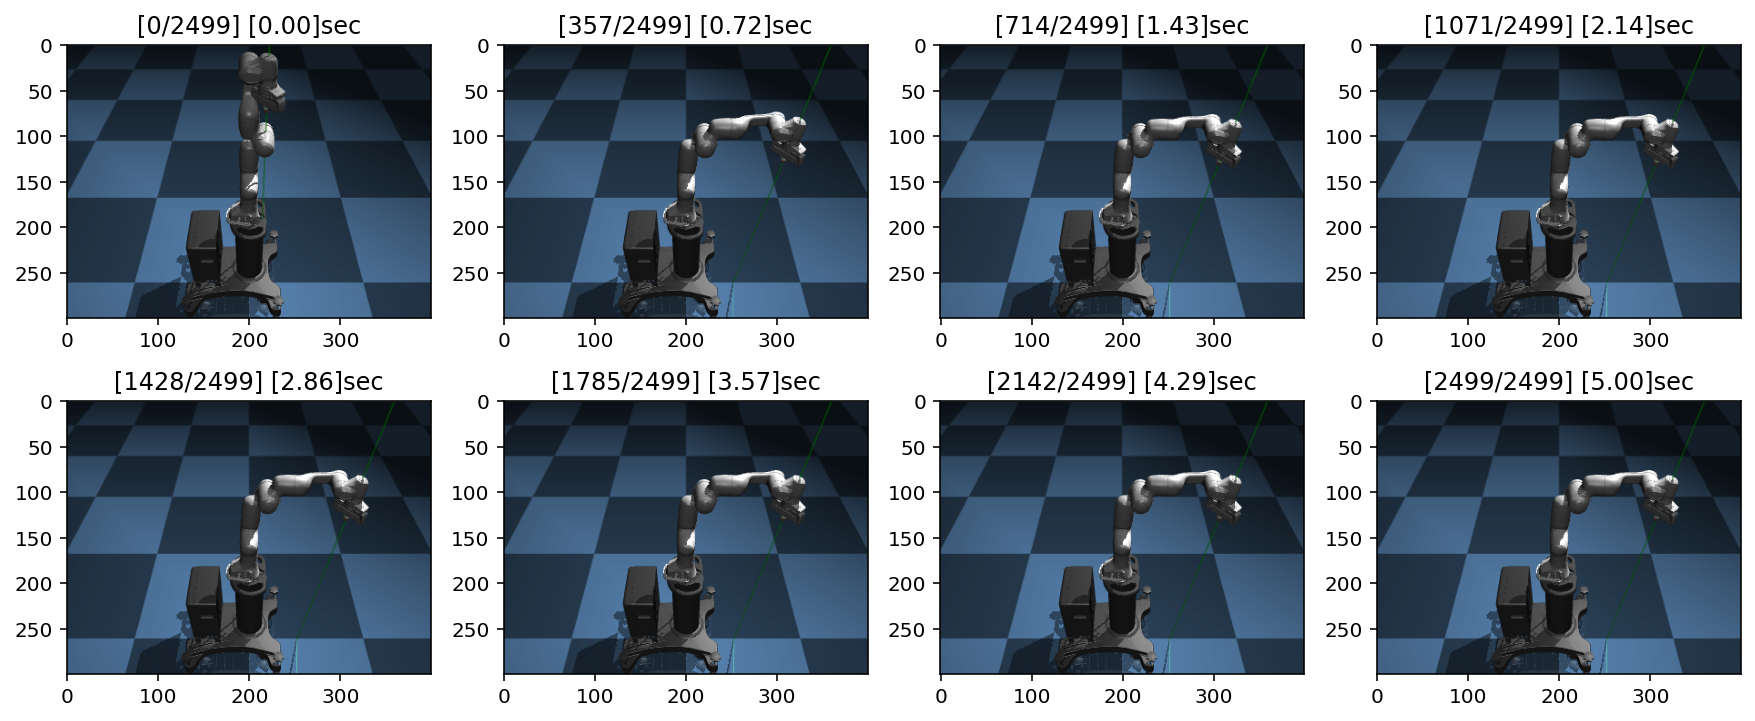

In [3]:
env.init_viewer(TERMINATE_GLFW=True,INITIALIZE_GLFW=True)
fig = plt.figure(figsize=(15,6))
for idx,tick in enumerate(np.linspace(0,env.max_tick-1,8).astype(np.int32)):
    env.forward(q_pos=q_curr_list[tick,:],q_pos_idxs=env.rev_joint_idxs)
    img = env.plot_scene(render_w=400,render_h=300,
                         cam_distance=2.0,cam_elevation=-45,cam_lookat=[0,0,1.25],RETURN_IMG=True)
    ax = fig.add_subplot(2,4,idx+1)
    ax.imshow(img)
    ax.set_title('[%d/%d] [%.2f]sec'%(tick,env.max_tick-1,sec_sim_list[tick]),fontsize=12)

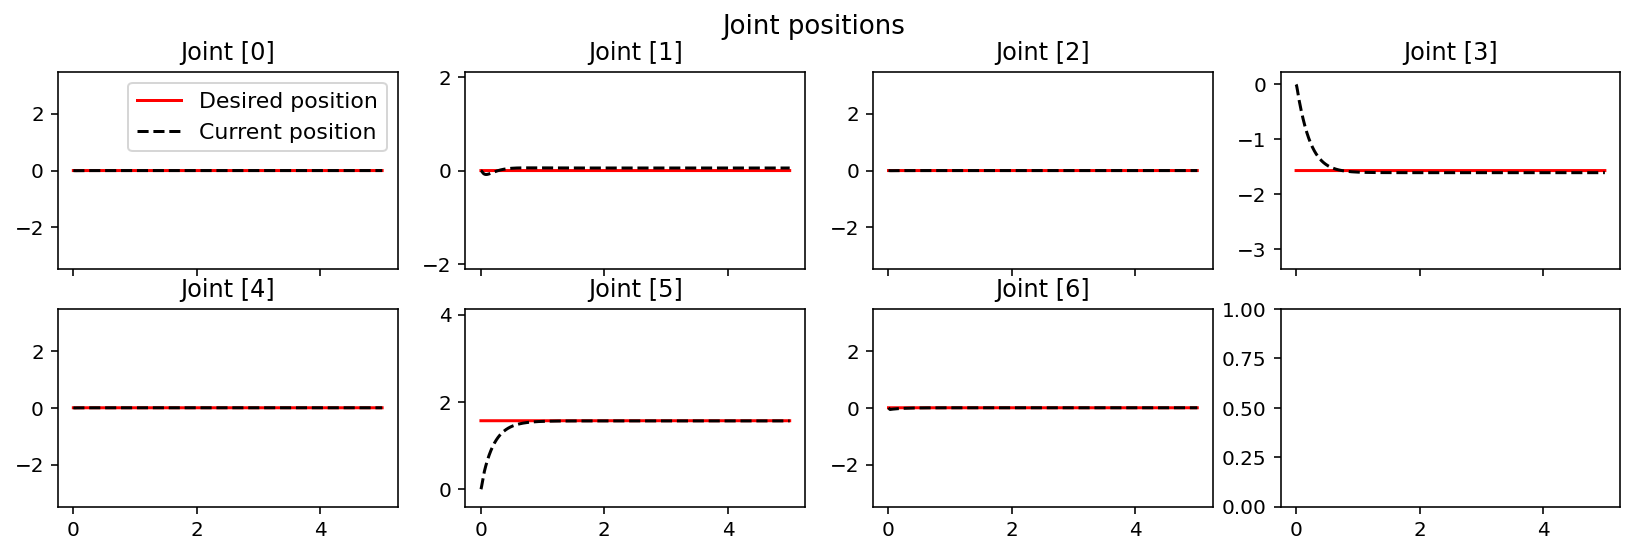

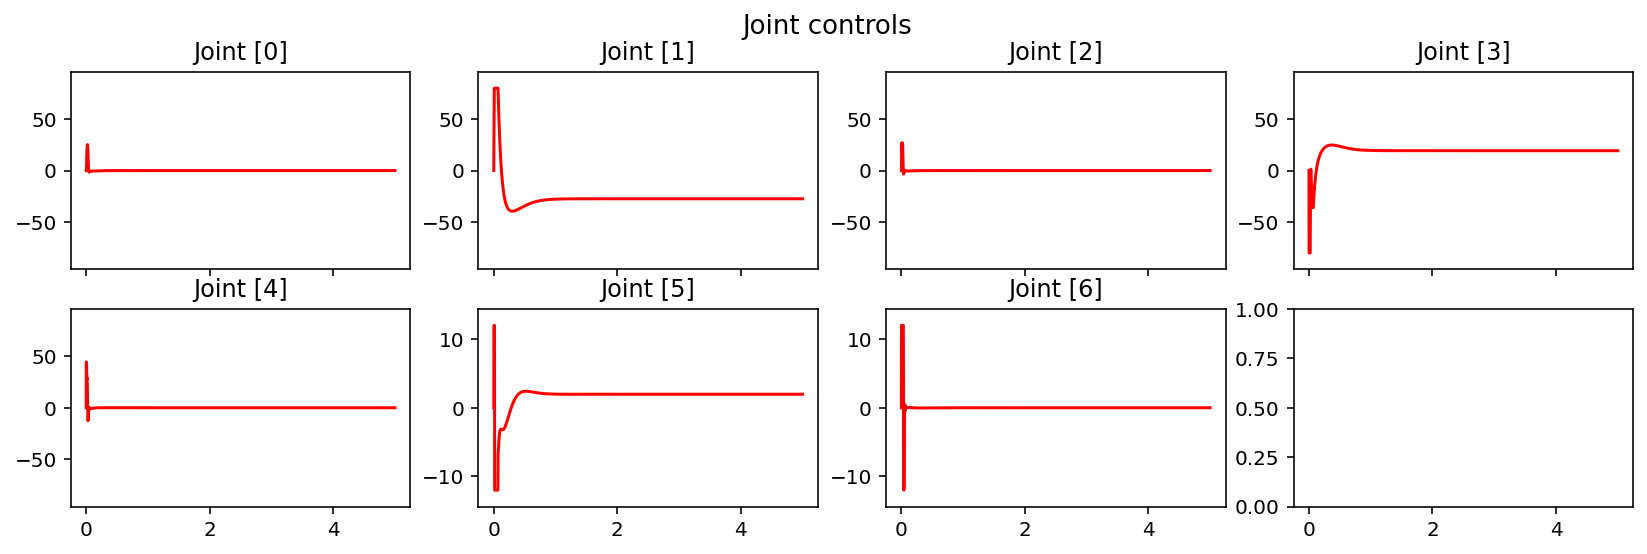

In [4]:
# Plot target and current joint position
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint positions", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,q_des_list[:,a_idx],'-',color='r',label='Desired position')
    ax.plot(sec_sim_list,q_curr_list[:,a_idx],'--',color='k',label='Current position')
    qmarg = 0.1*(env.joint_range[a_idx,1]-env.joint_range[a_idx,0])
    ax.set_ylim(bottom=env.joint_range[a_idx,0]-qmarg,top=env.joint_range[a_idx,1]+qmarg)
    ax.set_title('Joint [%d]'%(a_idx))
    if a_idx == 0: ax.legend(fontsize=11)
plt.show()
# Plot control output
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint controls", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,torque_list[:,a_idx],color='r')
    tmarg = 0.1*(env.torque_range[a_idx,1]-env.torque_range[a_idx,0])
    ax.set_ylim(bottom=env.torque_range[a_idx,0]-tmarg,top=env.torque_range[a_idx,1]+tmarg)
    ax.set_title('Joint [%d]'%(a_idx))
plt.show()